In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial

In [12]:
filter_first_up = ((ff.read('up').shift(1,axis = 1).replace({1:0,np.nan:1})) * ff.read('up')).replace({0:np.nan})*ff.filter0
filtered_index = filter_first_up.index.str.startswith('300') | filter_first_up.index.str.startswith('688') | filter_first_up.index.str.endswith('BJ')
filter_first_up.loc[filtered_index,:] = np.nan
filter_first_up = filter_first_up.loc[:,'20200102':'20240305']

In [34]:
filter_first_up.sum()

20200102    39.0
20200103    26.0
20200106    42.0
20200107    36.0
20200108    23.0
            ... 
20240228    14.0
20240229    79.0
20240301    35.0
20240304    54.0
20240305    31.0
Length: 1010, dtype: float64

In [32]:
day = '20200102'    
stock_ret_list = []
for i in range(len(filter_first_up.loc[:,day].dropna().index)):
    stock = filter_first_up.loc[:,day].dropna().index[i]
    a = (ff.read_min(stock).iloc[:,1]/ff.read_min(stock).iloc[:,1].shift(1)-1).fillna(0) #计算出每一分钟的收益率
    formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(a.index)] #生成所有的分钟时间index
    time_start = formatted_date_list.index(day) 
    stock_ret_list.append(a.iloc[time_start+240:time_start+1440].values)#筛选每支股票首次涨停的1200行数据

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:52<00:00,  1.34s/it]


In [35]:
 range(len(filter_first_up.loc[:,day].dropna().index))

range(0, 39)

In [36]:
filter_first_up.loc[:,day].dropna().index[i]

'603987.SH'

In [40]:
stock = filter_first_up.loc[:,day].dropna().index[0]

In [46]:
(ff.read_min(stock).iloc[:,1]/ff.read_min(stock).iloc[:,1].shift(1)-1).fillna(0)

2020-01-02 09:31:00    0.000000
2020-01-02 09:32:00   -0.005636
2020-01-02 09:33:00    0.002429
2020-01-02 09:34:00    0.000000
2020-01-02 09:35:00    0.001616
                         ...   
2024-03-15 14:56:00    0.000000
2024-03-15 14:57:00   -0.000841
2024-03-15 14:58:00    0.000000
2024-03-15 14:59:00    0.000000
2024-03-15 15:00:00    0.001684
Name: close, Length: 244320, dtype: float64

In [47]:
formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(a.index)] #生成所有的分钟时间index
time_start = formatted_date_list.index(day) 
a.iloc[time_start:time_start+1440].values

array([ 0.        , -0.00563607,  0.00242915, ...,  0.        ,
        0.        ,  0.00068493])

In [43]:
time_start

0

In [135]:
def stock_ret_mean(i):
    day = filter_first_up.columns[i]
    stock_ret_list = []
    for i in range(len(filter_first_up.loc[:,day].dropna().index)):
        stock = filter_first_up.loc[:,day].dropna().index[i]
        formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min(stock).index)] #生成所有的分钟时间index
        time_start = formatted_date_list.index(day) 
        stock_ret_list.append((ff.read_min(stock).iloc[time_start+240:time_start+1440,1]/ff.read_min(stock).iloc[time_start+239,1]).values)
    ret_aver = np.mean(stock_ret_list, axis=0)
    return ret_aver

In [59]:
np.mean(ret_mean,axis = 0)

array([ 1.63300035e-02,  8.09190974e-04, -3.12590973e-04, ...,
        3.26908530e-05,  0.00000000e+00, -5.45483177e-05])

0.016821566095989816


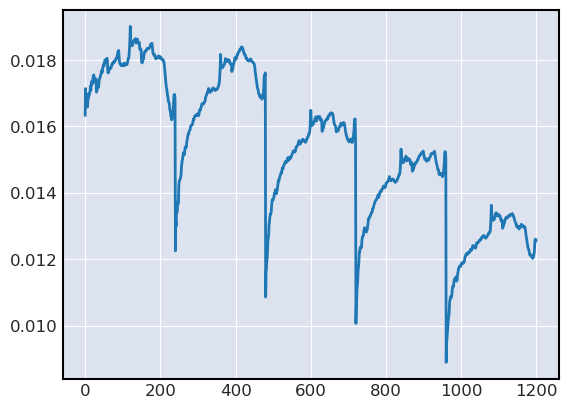

In [94]:
plt.plot(np.mean(ret_mean,axis = 0).cumsum())
print(np.mean(ret_mean,axis = 0).cumsum()[239])

In [15]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/T0open
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/T0open
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    print(data)
    mpf.plot(data,type='candle',style='default')
    return data

                open     close       low      high
2020-01-01  1.000000  1.143790  0.988383  1.177668
2020-01-02  1.110025  1.133157  1.070276  1.182922
2020-01-03  1.110861  1.132059  1.073035  1.180442
2020-01-04  1.112609  1.133004  1.074955  1.179737
2020-01-05  1.112397  1.133071  1.075761  1.177287


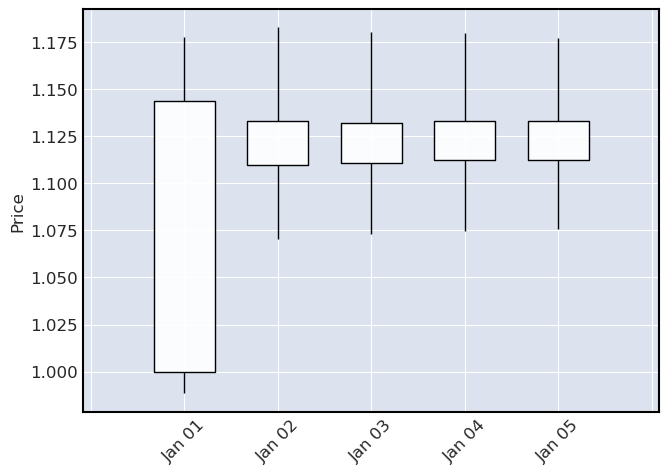

,open,close,low,high
2020-01-01,1.000000,1.143790,0.988383,1.177668
2020-01-02,1.110025,1.133157,1.070276,1.182922
2020-01-03,1.110861,1.132059,1.073035,1.180442
2020-01-04,1.112609,1.133004,1.074955,1.179737
2020-01-05,1.112397,1.133071,1.075761,1.177287


In [17]:
open = ff.read('open')*ff.read('post').loc[:,'20200102':]
close = ff.read('close')*ff.read('post').loc[:,'20200102':]
high = ff.read('high')*ff.read('post').loc[:,'20200102':]
low = ff.read('low')*ff.read('post').loc[:,'20200102':]
daily_K_line(filter_first_up,5,open,close,high,low)

In [70]:
stock_ret_mean(0).cumsum()

array([0.03232854, 0.03066309, 0.02995115, ..., 0.06266878, 0.06266878,
       0.06294887])

In [134]:
day = '20200706'
stock_ret_list = []
# for i in range(len(filter_first_up.loc[:,day].dropna().index)):
#     stock = filter_first_up.loc[:,day].dropna().index[i]
stock = '000001.SZ'
formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min('000001.SZ').index)] #生成所有的分钟时间index
time_start = formatted_date_list.index(day) 
a = (ff.read_min('000001.SZ').iloc[time_start+240:time_start+1440,1]/ff.read_min('000001.SZ').iloc[time_start+239,1]).values

array([1.0567602 , 1.04528061, 1.04464286, ..., 0.94897959, 0.94897959,
       0.94961735])

In [118]:
ff.read_min(stock).iloc[time_start+239:time_start+1440]

,open,close,low,high,volume,money,high_limit,low_limit,paused
2020-07-06 15:00:00,15.68,15.68,15.68,15.68,1271560.0,19938060.0,15.68,12.83,0.0
2020-07-07 09:31:00,16.30,16.57,16.21,16.57,30759422.0,502721874.0,17.25,14.11,0.0
2020-07-07 09:32:00,16.52,16.39,16.39,16.63,14647685.0,241879861.0,17.25,14.11,0.0
2020-07-07 09:33:00,16.37,16.38,16.30,16.38,8756139.0,143001739.0,17.25,14.11,0.0
2020-07-07 09:34:00,16.35,16.40,16.35,16.50,10467274.0,172005600.0,17.25,14.11,0.0
...,...,...,...,...,...,...,...,...,...
2020-07-13 14:56:00,14.87,14.88,14.86,14.88,745764.0,11092055.0,16.35,13.37,0.0
2020-07-13 14:57:00,14.88,14.88,14.87,14.89,803100.0,11949488.0,16.35,13.37,0.0
2020-07-13 14:58:00,14.88,14.88,14.88,14.88,27500.0,409275.0,16.35,13.37,0.0
2020-07-13 14:59:00,14.88,14.88,14.88,14.88,0.0,0.0,16.35,13.37,0.0


In [299]:
filter_st_up = ((ff.read('up_limit')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)<0.055).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st_down = ((ff.read('close')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)>0.049).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st = filter_st_up * filter_st_down # st股票涨停日期矩阵

In [301]:
filter_first_up = ((filter_st.shift(-1,axis = 1).replace({1:0,np.nan:1})) * filter_st).replace({0:np.nan})
filter_first_up = ((filter_first_st.shift(1,axis = 1).replace({1:0,np.nan:1})) * filter_first_up).replace({0:np.nan})
filter_first_up = filter_first_up.loc[:,'20200102':'20240305']

In [13]:
def stock_ret_mean(i):
    day = filter_first_up.columns[i]
    stock_ret_list = []
    for i in range(len(filter_first_up.loc[:,day].dropna().index)):
        if len(filter_first_up.loc[:,day].dropna().index) == 0:
            pass
        stock = filter_first_up.loc[:,day].dropna().index[i]
        formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min(stock).index)] #生成所有的分钟时间index
        time_start = formatted_date_list.index(day) 
        stock_ret_list.append((ff.read_min(stock).iloc[time_start+240:time_start+1440,1]/ff.read_min(stock).iloc[time_start+239,1]).values)
    ret_aver = np.mean(stock_ret_list, axis=0)
    return ret_aver

In [304]:
ret_st_mean = []
with Pool(48) as p:
    ret_st_mean = list(tqdm(p.imap(stock_ret_mean, range(len(filter_first_up.columns))), total=len(filter_first_up.columns)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:08<00:00,  5.35it/s]


In [309]:
mean_without_nan = [arr[~np.isnan(arr)] for arr in ret_st_mean]
mean_without_nan = [arr for arr in mean_without_nan if len(arr) > 0]

In [311]:
mean = np.mean(mean_without_nan,axis = 0)

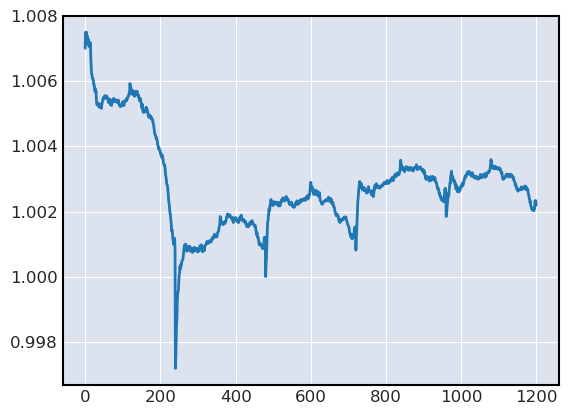

In [313]:
plt.plot(mean)

                open     close       low      high
2020-01-01  1.000000  1.050427  0.991456  1.050434
2020-01-02  1.050851  1.051289  1.022938  1.082812
2020-01-03  1.040115  1.051968  1.019945  1.075701
2020-01-04  1.042938  1.052106  1.022632  1.075993
2020-01-05  1.044051  1.053568  1.023817  1.076340


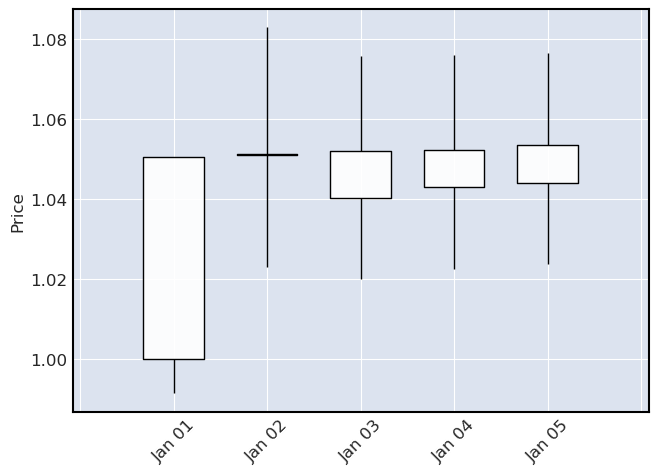

,open,close,low,high
2020-01-01,1.000000,1.050427,0.991456,1.050434
2020-01-02,1.050851,1.051289,1.022938,1.082812
2020-01-03,1.040115,1.051968,1.019945,1.075701
2020-01-04,1.042938,1.052106,1.022632,1.075993
2020-01-05,1.044051,1.053568,1.023817,1.076340


In [303]:
daily_K_line(filter_first_up,5,open,close,high,low)

In [302]:
filter_first_up.loc[:,'20200107'].dropna()

000911.SZ    1.0
002306.SZ    1.0
600179.SH    1.0
600228.SH    1.0
600289.SH    1.0
603779.SH    1.0
Name: 20200107, dtype: float64

In [287]:
filter_st.loc['000868.SZ','20191231':'20240305'].dropna()

20200106    1.0
20200107    1.0
20200210    1.0
20200226    1.0
20200227    1.0
20200327    1.0
20200508    1.0
20200527    1.0
20200611    1.0
20200612    1.0
20200708    1.0
20201012    1.0
20201015    1.0
20201111    1.0
20201120    1.0
20201123    1.0
20201218    1.0
20210115    1.0
20210127    1.0
20210323    1.0
Name: 000868.SZ, dtype: float64

In [315]:
min_data = pd.read_pickle('/mydata2/wangs/data/fmins/close.pk')

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,600890.SH,600891.SH,600896.SH,600978.SH,601258.SH,601558.SH,603157.SH,603996.SH,688086.SH,688555.SH
2020-01-02 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:32:00,16.70,33.01,22.85,3.13,5.42,9.55,3.66,6.26,3.40,9.49,...,6.33,1.49,4.28,3.00,1.42,1.10,5.80,4.91,NaN,NaN
2020-01-02 09:33:00,16.83,33.10,22.78,3.14,5.41,9.48,3.65,6.21,3.41,9.45,...,6.36,1.48,4.28,2.99,1.42,1.09,5.78,4.91,NaN,NaN
2020-01-02 09:34:00,16.77,33.18,22.70,3.14,5.42,9.46,3.65,6.27,3.42,9.44,...,6.37,1.49,4.29,3.00,1.41,1.09,5.80,4.91,NaN,NaN
2020-01-02 09:35:00,16.80,33.44,22.49,3.14,5.42,9.50,3.64,6.26,3.42,9.45,...,6.37,1.49,4.28,3.00,1.41,1.09,5.81,4.91,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-27 14:56:00,10.50,10.05,13.56,0.88,4.11,4.21,2.18,11.95,2.40,8.56,...,0.36,0.38,1.12,0.52,0.40,0.25,0.59,0.39,0.64,1.12
2024-02-27 14:57:00,10.50,10.05,13.56,0.88,4.11,4.21,2.18,11.94,2.40,8.57,...,0.36,0.38,1.12,0.52,0.40,0.25,0.59,0.39,0.64,1.12
2024-02-27 14:58:00,10.50,10.06,13.56,0.88,4.12,4.21,2.19,11.95,2.39,8.55,...,0.36,0.38,1.12,0.52,0.40,0.25,0.59,0.39,0.64,1.12
2024-02-27 14:59:00,10.50,10.05,13.56,0.88,4.12,4.21,2.19,11.95,2.39,8.55,...,0.36,0.38,1.12,0.52,0.40,0.25,0.59,0.39,0.64,1.12


In [320]:
filter_first_up = ((ff.read('up').shift(1,axis = 1).replace({1:0,np.nan:1})) * ff.read('up')).replace({0:np.nan})*ff.filter0
filtered_index = filter_first_up.index.str.startswith('300') | filter_first_up.index.str.startswith('688') | filter_first_up.index.str.endswith('BJ')
filter_first_up.loc[~filtered_index,:] = np.nan
filter_first_up = filter_first_up.loc[:,'20200102':'20240305']

In [321]:
ret_st_mean = []
with Pool(48) as p:
    ret_st_mean = list(tqdm(p.imap(stock_ret_mean, range(len(filter_first_up.columns))), total=len(filter_first_up.columns)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [03:54<00:00,  4.31it/s]


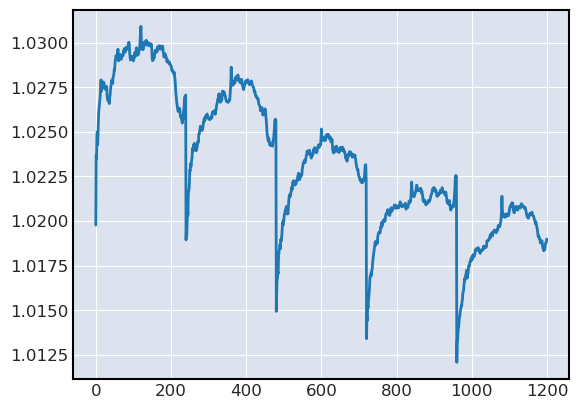

In [322]:
mean_without_nan = [arr[~np.isnan(arr)] for arr in ret_st_mean]
mean_without_nan = [arr for arr in mean_without_nan if len(arr) > 0]
mean = np.mean(mean_without_nan,axis = 0)
plt.plot(mean)

                open     close       low      high
2020-01-01  1.000000  1.183456  0.990017  1.183456
2020-01-02  1.180415  1.215879  1.123376  1.288929
2020-01-03  1.177350  1.213873  1.129434  1.277366
2020-01-04  1.174968  1.210189  1.129432  1.269155
2020-01-05  1.171945  1.210260  1.130174  1.263714


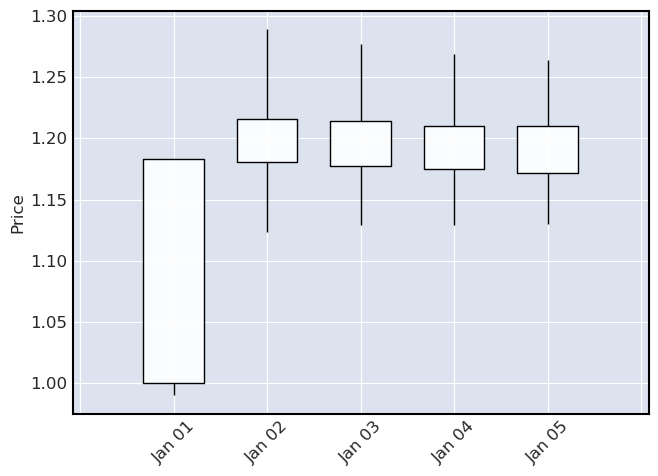

,open,close,low,high
2020-01-01,1.000000,1.183456,0.990017,1.183456
2020-01-02,1.180415,1.215879,1.123376,1.288929
2020-01-03,1.177350,1.213873,1.129434,1.277366
2020-01-04,1.174968,1.210189,1.129432,1.269155
2020-01-05,1.171945,1.210260,1.130174,1.263714


In [323]:
daily_K_line(filter_first_up,5,open,close,high,low)

In [333]:
ff.read('close')/ff.read('close').shift(axis = 1) >1.12

,20100104,20100105,20100106,20100107,20100108,20100111,20100112,20100113,20100114,20100115,...,20240305,20240306,20240307,20240308,20240311,20240312,20240313,20240314,20240315,20240318
000001.SZ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
000002.SZ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
000004.SZ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
000005.SZ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
000006.SZ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873703.BJ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
873706.BJ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
873726.BJ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
873806.BJ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
filter_first_up = ((ff.read('up').replace({1:np.nan,np.nan:1}) * ((ff.read('close') * ff.read('post'))/(ff.read('close')*ff.read('post')).shift(axis = 1) >=1.12))).replace({0:np.nan}) * ff.filter0
filtered_index = filter_first_up.index.str.startswith('300') | filter_first_up.index.str.startswith('688')
filter_first_up.loc[~filtered_index,:] = np.nan
filter_first_up = filter_first_up.loc[:,'20200825':'20240305']
filter_first_up.sum().sum()

4969.0

In [10]:
filter_first_up['20200825'].dropna()

300051.SZ    1.0
300071.SZ    1.0
300131.SZ    1.0
300135.SZ    1.0
300185.SZ    1.0
300240.SZ    1.0
300261.SZ    1.0
300343.SZ    1.0
300350.SZ    1.0
300386.SZ    1.0
300798.SZ    1.0
300801.SZ    1.0
Name: 20200825, dtype: float64

100%|███████████████████████████████████████████████████████████████████████████████████████████| 854/854 [08:33<00:00,  1.66it/s]


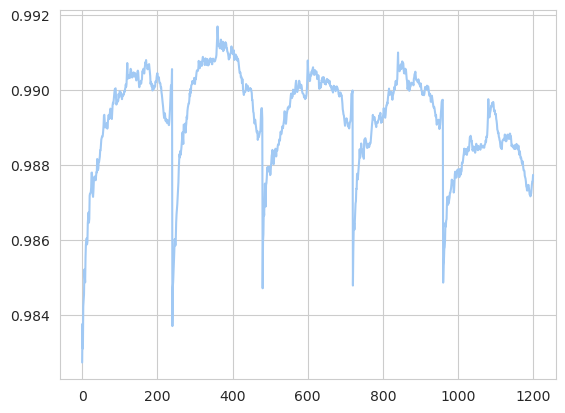

In [14]:
ret_st_mean = []
with Pool(48) as p:
    ret_st_mean = list(tqdm(p.imap(stock_ret_mean, range(len(filter_first_up.columns))), total=len(filter_first_up.columns)))
mean_without_nan = [arr[~np.isnan(arr)] for arr in ret_st_mean]
mean_without_nan = [arr for arr in mean_without_nan if len(arr) > 0]
mean = np.mean(mean_without_nan,axis = 0)
plt.plot(mean)

                open     close       low      high
2020-01-01  1.000000  1.143790  0.988383  1.177668
2020-01-02  1.110025  1.133157  1.070276  1.182922
2020-01-03  1.110861  1.132059  1.073035  1.180442
2020-01-04  1.112609  1.133004  1.074955  1.179737
2020-01-05  1.112397  1.133071  1.075761  1.177287


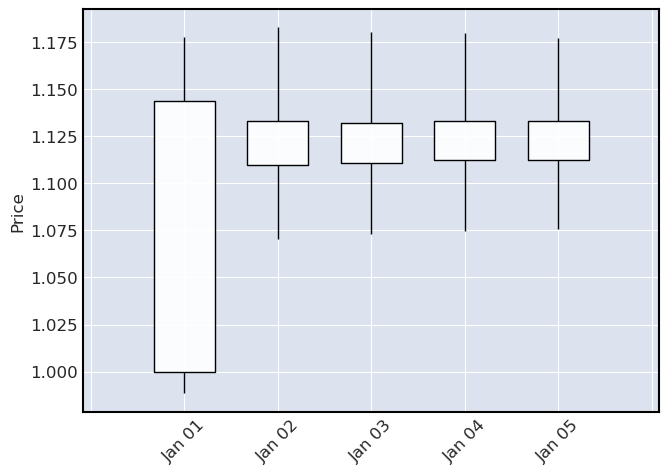

,open,close,low,high
2020-01-01,1.000000,1.143790,0.988383,1.177668
2020-01-02,1.110025,1.133157,1.070276,1.182922
2020-01-03,1.110861,1.132059,1.073035,1.180442
2020-01-04,1.112609,1.133004,1.074955,1.179737
2020-01-05,1.112397,1.133071,1.075761,1.177287


In [18]:
daily_K_line(filter_first_up,5,open,close,high,low)